In [1]:
import os
import cv2
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# dl imports
import torch

## CARLA dataset

In [2]:
from config import GlobalConfig
from data import CARLA_Data

root_dir = '/home/surya/Downloads/transfuser-2022/data/demo/scenario1/'
config = GlobalConfig()
demo_set = CARLA_Data(root=root_dir, config=config, routeKey='route0')
print(f"There are {len(demo_set)} samples in Demo dataset")

100%|██████████| 1/1 [00:00<00:00, 163.29it/s]
There are 98 samples in Demo dataset


Create pytorch style dataloaders

In [3]:
from torch.utils.data import DataLoader
dataloader_demo = DataLoader(demo_set, shuffle=False, batch_size=2, num_workers=4)

In [4]:
sample_data = next(iter(dataloader_demo))
print(f"sample data is of type {type(sample_data)} and has following keys")

for k,v in sample_data.items():
    print(k, list(v.shape))
    
del sample_data

sample data is of type <class 'dict'> and has following keys
rgb [2, 3, 160, 704]
bev [2, 160, 160]
depth [2, 160, 704]
semantic [2, 160, 704]
speed [2]
x_command [2]
y_command [2]
target_point [2, 2]
target_point_image [2, 1, 256, 256]
lidar [2, 2, 256, 256]
label [2, 20, 7]
ego_waypoint [2, 4, 2]


## Load pretrained model

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

from model import LidarCenterNet
model = LidarCenterNet(config, device, config.backbone, image_architecture='regnety_032', 
                           lidar_architecture='regnety_032', use_velocity=False)
model.to(device);
model.config.debug = True

model.eval();
checkpt = torch.load('/home/surya/Downloads/transfuser-2022/model_ckpt/transfuser/transfuser_regnet032_seed1_39.pth', map_location=device)
model.load_state_dict(checkpt)

<All keys matched successfully>

In [6]:
# from collections import OrderedDict
# new_state_dict = OrderedDict()

# for k,v in checkpt.items():
#     new_key = k.replace("module.", "")
#     if new_key != '_model.lidar_encoder._model.stem.conv.weight':
#         new_state_dict[new_key] = v
# torch.save(new_state_dict, 'transfuser_regnet032_seed1_39.pth')

In [7]:
test_data = next(iter(dataloader_demo))

# load data to gpu, according to type
for k in ['rgb', 'depth', 'lidar', 'label', 'ego_waypoint', \
          'target_point', 'target_point_image', 'speed']:
    test_data[k] = test_data[k].to(device, torch.float32)
for k in ['semantic', 'bev']:
    test_data[k] = test_data[k].to(device, torch.long)
    
_, debug_outputs = model(test_data)    

/home/surya/miniconda3/envs/tfuse/lib/python3.7/site-packages/mmdet/models/utils/gaussian_target.py:227: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  topk_clses = topk_inds // (height * width)
/home/surya/miniconda3/envs/tfuse/lib/python3.7/site-packages/mmdet/models/utils/gaussian_target.py:229: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='fl

In [8]:
i = 0

In [9]:
rgb_image = test_data['rgb'][i].permute(1, 2, 0).detach().cpu().numpy().astype(np.uint8)

pred_depth = debug_outputs['pred_depth'][i]

indices = np.argmax(debug_outputs['pred_semantic'], axis=1)
pred_semantic = np.array(config.classes_list)[indices[i, ...], ...].astype('uint8')        

pred_bev = debug_outputs['pred_bev'][i].argmax(axis=0).astype(np.uint8)
print(np.unique(pred_bev))

lidar_bev = test_data['bev'][i]

color_code = np.array([
    [0, 0, 0],  # black
    [128, 128, 128],
    [255, 255, 0]
])

[0 1 2]


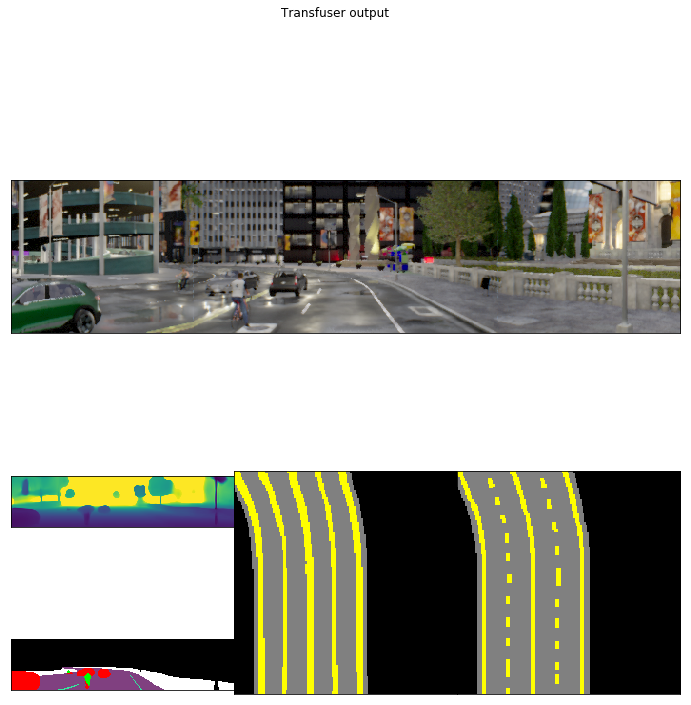

In [19]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(12, 12))
fig.suptitle("Transfuser output")
fig.tight_layout()

gs = fig.add_gridspec(3, 3,  height_ratios = [2,1,1], wspace=0, hspace=0)
rgb_axes = fig.add_subplot(gs[0, :])
depth_axes = fig.add_subplot(gs[1, 0])
semantic_axes = fig.add_subplot(gs[2, 0])
bev_axes = fig.add_subplot(gs[1:, 1])
bbox_axes = fig.add_subplot(gs[1:, 2])

rgb_axes.imshow(rgb_image)
rgb_axes.set(xticks=[], yticks=[])


depth_axes.imshow(pred_depth)
depth_axes.set(xticks=[], yticks=[])

semantic_axes.imshow(pred_semantic)
semantic_axes.set(xticks=[], yticks=[])

bev_axes.imshow(color_code[pred_bev])
bev_axes.set(xticks=[], yticks=[])

bbox_axes.imshow(color_code[lidar_bev])
bbox_axes.set(xticks=[], yticks=[])

gs.update(wspace=0.0, hspace=0.0)